# EDA

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
import missingno
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)


In [2]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")



def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances



def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax


def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax


def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)


In [3]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs


In [4]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax


def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [5]:
def get_coeffs_logreg(logreg, feature_names = None, sort=True,ascending=True,
                      name='LogReg Coefficients', class_index=0,  
                      include_intercept=False, as_odds=False):
    
    if feature_names is None:
        feature_names = logreg.feature_names_in_
        
    ## Saving the coefficients
    coeffs = pd.Series(logreg.coef_[class_index],
                       index= feature_names, name=name)
    
    if include_intercept:
        # use .loc to add the intercept to the series
        coeffs.loc['intercept'] = logreg.intercept_[class_index]
        
    if as_odds==True:
        coeffs = np.exp(coeffs)
    if sort == True:
        coeffs = coeffs.sort_values(ascending=ascending)
    
        
    return coeffs


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.2}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'



In [7]:
def evaluate_classification(model, X_train,y_train,X_test,y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")
    ## training data
    print('[i] Training Data:')
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize,
                                                   cmap=cmap,ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    
    fig.tight_layout()
    plt.show()
     
    print(dashes)
    ## test data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize,
                                                   cmap=cmap, ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()



#  Explaining Models with Shap

## Loading

In [21]:
from joblib import load

# Load the joblib file
file_path = '/Users/corycates/Documents/random_forest_l01.joblib'
loaded = load(file_path)

# Inspecting the keys in the loaded joblib file to understand the contents
loaded.keys()



dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'RandomForest'])

In [22]:
X_train_df = loaded['X_train']
y_train = loaded['y_train']
X_test_df = loaded['X_test']
y_test = loaded['y_test']
preprocessor = loaded['preprocessor']
loaded_model = loaded['RandomForest']



Training Data:	R^2= 0.94	RMSE= 422.03
Test Data:	R^2= 0.56	RMSE= 1161.55


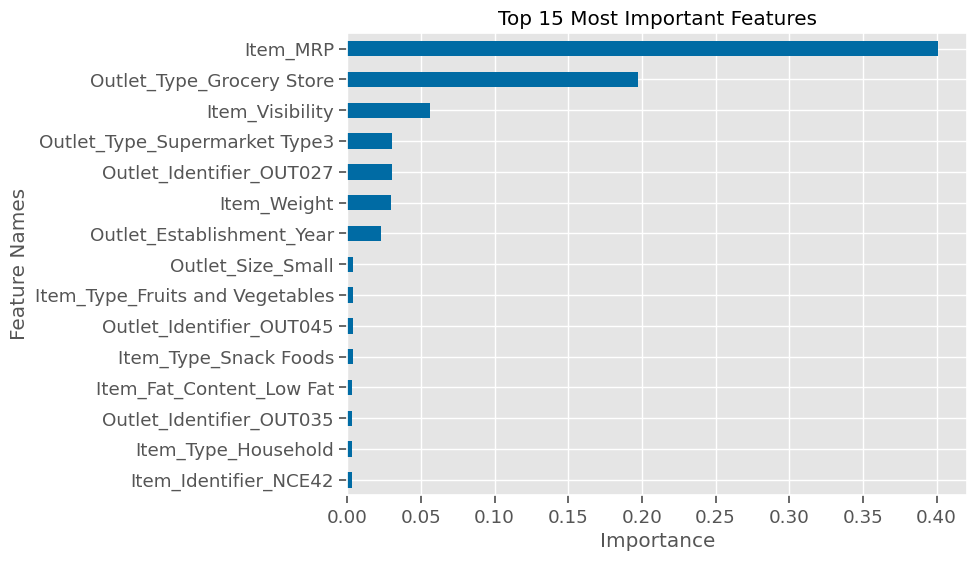

In [23]:
evaluate_regression(loaded_model,X_train_df, y_train, X_test_df,y_test)
loaded_importances = get_importances(loaded_model)
plot_importance_color(loaded_importances,top_n=15,color_dict=None);



In [24]:

## fit random fores
loaded_model = RandomForestRegressor()
loaded_model.fit(X_train_df,y_train)

RandomForestRegressor()

## Explaining the model

In [26]:
# Import shap and initialize javascript:
import shap
shap.initjs()



In [27]:
len(X_train_df)



6392

In [28]:
X_shap = shap.sample(X_train_df,nsamples=400,random_state=321)
X_shap.head()


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,Item_Identifier_DRB25,Item_Identifier_DRB48,Item_Identifier_DRC01,Item_Identifier_DRC12,Item_Identifier_DRC13,Item_Identifier_DRC24,Item_Identifier_DRC25,Item_Identifier_DRC27,Item_Identifier_DRC36,Item_Identifier_DRC49,Item_Identifier_DRD01,Item_Identifier_DRD12,Item_Identifier_DRD13,Item_Identifier_DRD15,Item_Identifier_DRD24,...,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4469,7.72,0.074669,76.3986,1987.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4438,5.11,0.034868,163.8210,2004.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
366,8.05,0.078386,256.4646,2004.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2219,8.76,0.050131,128.3336,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6080,6.59,0.176748,82.7908,1998.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [29]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap.head()



4469    1402.1748
4438    2120.5730
366     5153.2920
2219    2556.6720
6080      83.8908
Name: Item_Outlet_Sales, dtype: float64

In [33]:
#explainer = shap.Explainer(loaded_model)
#explainer

# Create a model explainer with interventional feature perturbation
explainer = shap.TreeExplainer(loaded_model, feature_perturbation='interventional')

# Calculate the SHAP values for the model and disable the additivity check
shap_values = explainer.shap_values(X_shap, check_additivity=False)

print(type(shap_values))
shap_values.shape



<class 'numpy.ndarray'>


(400, 1600)

## Create a Summary Plot Bar and Dot

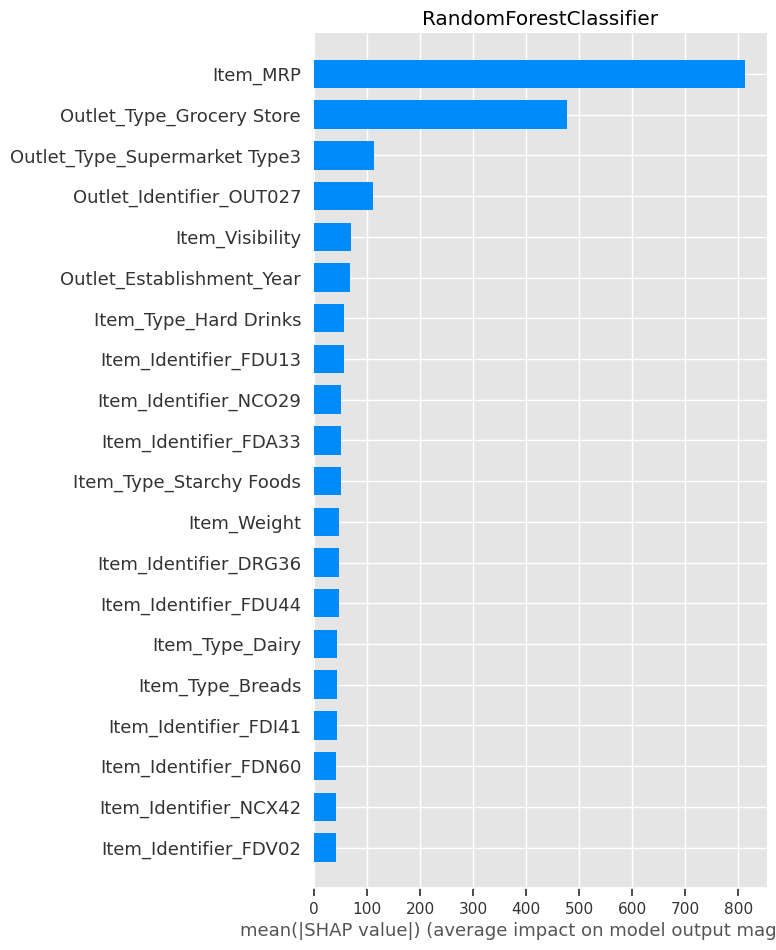

In [38]:
##  saving class as separate var first
shap_vals_1 = shap_values[:,1]
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_shap, plot_type='bar', show=False)
ax.set_title('RandomForestClassifier');
           



1. SHAP Summary Bar Plot Analysis: Insights into Features Impacting Item Outlet Sales
The comparison between the original Random Forest model and the SHAP Summary Bar Plot reveals nuanced insights into the importance of different features, primarily ‘Item MRP’, ‘Outlet Type’, and ‘Item Visibility’, and their influence on Item Outlet Sales.

Model Interpretation:
Item MRP:
Both the Random Forest model and the SHAP Summary Bar Plot underscore the substantial reliance on ‘Item MRP’ for predicting Item Outlet Sales. This highlights ‘Item MRP’ as a cornerstone feature in shaping the predictions, with it being a predominant factor in the model's decision-making process.

Outlet Type:
‘Outlet Type’ emerges as another pivotal feature in both analyses, holding significant weight in the model's predictions of Item Outlet Sales. It is evident that ‘Outlet Type’ is a major player in how the model perceives and processes the data to generate its predictions.

Item Visibility:
The analyses reflect the considerable importance assigned to ‘Item Visibility’. The model’s dependency on this feature to make accurate predictions is evident, indicating that it is crucial for understanding the internal mechanics of how the model generates its predictions.

Comparative Insights:
The SHAP Summary Bar Plot provides a more granular view of the influence of each feature, allowing for a refined understanding of their contributions to the model’s predictions. It provides a detailed breakdown of the importance of each feature, helping to unravel the intricate dynamics embedded within the model’s structure.

The Random Forest model’s feature importances give a broad overview of the features’ significance, but the SHAP analysis delves deeper, offering more detailed insights into how each feature individually impacts the model’s predictions.

While the Random Forest model emphasizes the overall importance of features in a generalized manner, the SHAP Summary Bar Plot meticulously dissects the contribution of each feature, revealing the subtle nuances in their roles in predicting Item Outlet Sales.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


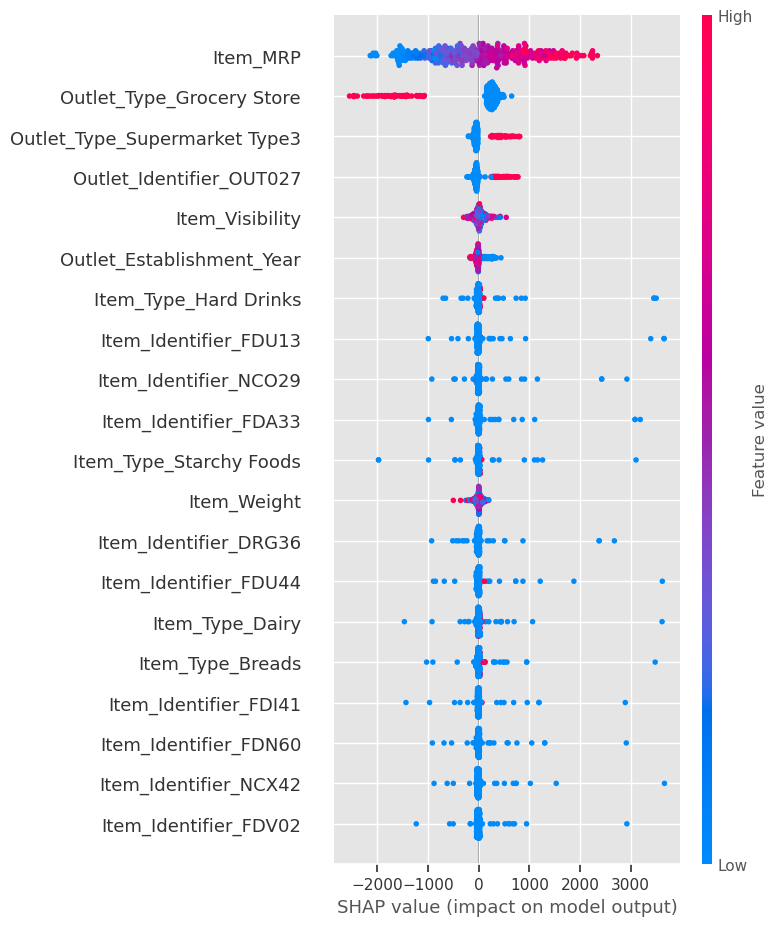

In [35]:
##  saving class as separate var first
shap_vals_1 = shap_values[:,1]
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_shap)
ax.set_title('RandomForestClassifier');



2. SHAP Summary Dot Plot Analysis: In-Depth Insight into Individual Feature Contributions
The SHAP Summary Dot Plot provides a sophisticated and nuanced perspective on how each pivotal feature, especially in relation to Item Outlet Sales, shapes the individual predictions formulated by the model, offering a more intricate understanding compared to the global view provided by the original Random Forest model.

Model Interpretation:
Individual Instance Contribution to Item Outlet Sales:
The Dot Plot unveils the distinct contribution of each top feature to the prediction of Item Outlet Sales for every individual instance. It facilitates a profound comprehension of the model’s utilization of these features in its predictive logic, showcasing the intricate interplay between different features and their respective influence on each prediction.

Direction and Magnitude of Influence on Item Outlet Sales:
The alignment and coloration of each dot delineate the direction and magnitude of each feature’s influence on the prediction of Item Outlet Sales. This serves to illuminate the complex dynamics and multifaceted relationships within the model’s predictive framework, providing a richer, more textured understanding of the model’s operational mechanism.

Comparative Insights:
The SHAP Summary Dot Plot provides granular, instance-specific insights, revealing how each feature’s value influences the model’s prediction for every individual observation, thereby uncovering the diverse ways in which features impact the model’s output. This contrasts with the generalized, aggregated insights provided by the Random Forest model, allowing for a more meticulous exploration of the model’s decision-making process.

The intricate details provided by the dot plot enhance our understanding of the model’s internal structure and its interaction with the features, enabling a closer examination of the subtleties and nuances inherent in the model’s predictions, as opposed to the broad overview provided by the Random Forest model.

The color coding in the SHAP dot plot, representing the value of the feature for each instance, adds another layer of interpretability, allowing for a comprehensive analysis of the relationship between feature values and their influence on the model’s predictions. This level of detail is absent in the insights provided by the Random Forest model, emphasizing the depth of understanding that can be achieved through SHAP analyses.

1. Original Random Forest Model Interpretation:
The original Random Forest model serves as a fundamental baseline, offering initial insights into which features the model deems important for predicting Item Outlet Sales, primarily focusing on ‘Item MRP’, ‘Outlet Type’, and ‘Item Visibility’.

2. SHAP Summary Bar Plot & Dot Plot Interpretations:
The SHAP analyses provide a more nuanced understanding of how the model utilizes the features to make predictions, giving more detailed insights into individual predictions and the intricate interplay between features within the model’s architecture.
